In [3]:
import pandas as pd
import tqdm
from Bio import SeqIO
import os
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
# import tensorflow
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, Embedding
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2


from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate


from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


2024-10-25 18:54:34.570071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-25 18:54:34.570131: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

In [5]:
def get_input_for_embedding(fasta_file):
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in data]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    return encodings

In [6]:
# convert sequences to integer encoding, for embedding
test_positive_embedding = get_input_for_embedding('../data/test/fasta/test_positive_sites.fasta')
test_negative_embedding = get_input_for_embedding('../data/test/fasta/test_negative_sites.fasta')
train_positive_embedding = get_input_for_embedding('../data/train/fasta/positive_sites.fasta')
train_negative_embedding = get_input_for_embedding('../data/train/fasta/negative_sites.fasta')

# create labels
train_positive_labels = np.ones(train_positive_embedding.shape[0])
train_negative_labels = np.zeros(train_negative_embedding.shape[0])
test_positive_labels = np.ones(test_positive_embedding.shape[0])
test_negative_labels = np.zeros(test_negative_embedding.shape[0])

# stack positive and negative data together
X_train_full_embedding = np.vstack((train_positive_embedding,train_negative_embedding))
X_test_embedding = np.vstack((test_positive_embedding,test_negative_embedding))
y_train_full = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

train_positive_pt5 = pd.read_csv("../data/train/features/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
train_negative_pt5 = pd.read_csv("../data/train/features/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_positive_pt5 = pd.read_csv("../data/test/features/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_negative_pt5 = pd.read_csv("../data/test/features/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]

# stack positive and negative data together
X_train_pt5_full = np.vstack((train_positive_pt5,train_negative_pt5))
X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))


In [8]:
# shuffle X and y together
# X_train_pt5_full, X_train_full_embedding, y_train = shuffle(X_train_pt5_full, X_train_full_embedding, y_train_full)
# X_test_pt5, X_test_embedding, y_test = shuffle(X_test_pt5, X_test_embedding, y_test)

In [42]:
# model.summary()
# plot_model(model, show_shapes=True)

In [7]:
def CNN_Embedding():
    # Embedding
    model = Sequential()
    model.add(Embedding(256, 21, input_length=33))
    model.add(Lambda(lambda x: K.expand_dims(x, 3)))
    model.add(Conv2D(32, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

### Iterated 10-Fold CROSS VALIDATION

Epoch 1/100


2024-10-25 18:57:37.728725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-25 18:57:37.732522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-25 18:57:37.732672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-10-25 18:57:37.732850: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-10-25 18:57:37.733084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

34/34 [==============================] - 3s 52ms/step - loss: 0.6947 - accuracy: 0.5108 - val_loss: 0.6924 - val_accuracy: 0.5895
Epoch 2/100
34/34 [==============================] - 1s 39ms/step - loss: 0.6899 - accuracy: 0.5360 - val_loss: 0.6857 - val_accuracy: 0.6032
Epoch 3/100
34/34 [==============================] - 1s 38ms/step - loss: 0.6712 - accuracy: 0.5940 - val_loss: 0.6561 - val_accuracy: 0.6453
Epoch 4/100
34/34 [==============================] - 1s 38ms/step - loss: 0.6417 - accuracy: 0.6228 - val_loss: 0.6258 - val_accuracy: 0.6747
Epoch 5/100
34/34 [==============================] - 1s 37ms/step - loss: 0.6187 - accuracy: 0.6563 - val_loss: 0.6097 - val_accuracy: 0.6832
Epoch 6/100
34/34 [==============================] - 1s 38ms/step - loss: 0.6075 - accuracy: 0.6652 - val_loss: 0.5974 - val_accuracy: 0.6874
Epoch 7/100
34/34 [==============================] - 1s 36ms/step - loss: 0.6011 - accuracy: 0.6773 - val_loss: 0.5928 - val_accuracy: 0.6937
Epoch 8/100
34/34 

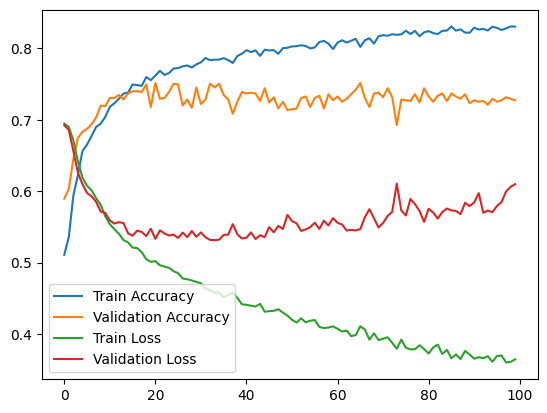

Epoch 1/100
34/34 [==============================] - 3s 44ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6926 - val_accuracy: 0.4989
Epoch 2/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6913 - accuracy: 0.5078 - val_loss: 0.6897 - val_accuracy: 0.5147
Epoch 3/100
34/34 [==============================] - 1s 34ms/step - loss: 0.6819 - accuracy: 0.5534 - val_loss: 0.6668 - val_accuracy: 0.6537
Epoch 4/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6527 - accuracy: 0.6059 - val_loss: 0.6391 - val_accuracy: 0.6537
Epoch 5/100
34/34 [==============================] - 1s 36ms/step - loss: 0.6334 - accuracy: 0.6278 - val_loss: 0.6282 - val_accuracy: 0.6653
Epoch 6/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6236 - accuracy: 0.6374 - val_loss: 0.6165 - val_accuracy: 0.6695
Epoch 7/100
34/34 [==============================] - 1s 34ms/step - loss: 0.6167 - accuracy: 0.6481 - val_loss: 0.6134 - val_accuracy: 0.6695
Epoch 

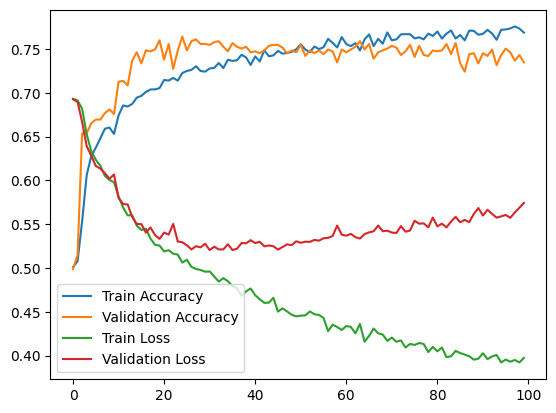

Epoch 1/100
34/34 [==============================] - 2s 40ms/step - loss: 0.6869 - accuracy: 0.5430 - val_loss: 0.6792 - val_accuracy: 0.5800
Epoch 2/100
34/34 [==============================] - 1s 38ms/step - loss: 0.6583 - accuracy: 0.6171 - val_loss: 0.6534 - val_accuracy: 0.6221
Epoch 3/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6326 - accuracy: 0.6522 - val_loss: 0.6353 - val_accuracy: 0.6579
Epoch 4/100
34/34 [==============================] - 1s 36ms/step - loss: 0.6164 - accuracy: 0.6665 - val_loss: 0.6280 - val_accuracy: 0.6611
Epoch 5/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6060 - accuracy: 0.6829 - val_loss: 0.6238 - val_accuracy: 0.6526
Epoch 6/100
34/34 [==============================] - 1s 37ms/step - loss: 0.5955 - accuracy: 0.6892 - val_loss: 0.6094 - val_accuracy: 0.6695
Epoch 7/100
34/34 [==============================] - 1s 35ms/step - loss: 0.5840 - accuracy: 0.7015 - val_loss: 0.6021 - val_accuracy: 0.6663
Epoch 

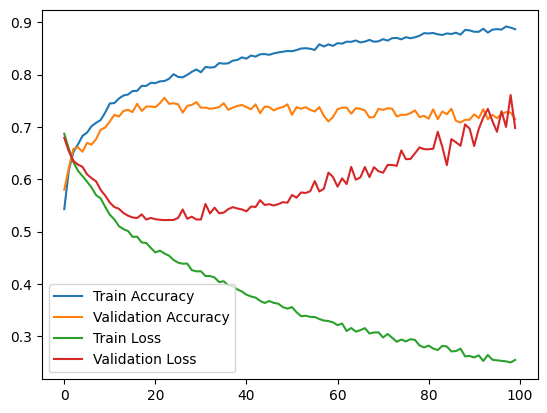

Epoch 1/100
34/34 [==============================] - 2s 40ms/step - loss: 0.6929 - accuracy: 0.5092 - val_loss: 0.6884 - val_accuracy: 0.5305
Epoch 2/100
34/34 [==============================] - 1s 36ms/step - loss: 0.6773 - accuracy: 0.5949 - val_loss: 0.6639 - val_accuracy: 0.6526
Epoch 3/100
34/34 [==============================] - 1s 36ms/step - loss: 0.6504 - accuracy: 0.6239 - val_loss: 0.6364 - val_accuracy: 0.6642
Epoch 4/100
34/34 [==============================] - 1s 36ms/step - loss: 0.6259 - accuracy: 0.6579 - val_loss: 0.6182 - val_accuracy: 0.6789
Epoch 5/100
34/34 [==============================] - 1s 36ms/step - loss: 0.6147 - accuracy: 0.6683 - val_loss: 0.6106 - val_accuracy: 0.6874
Epoch 6/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6050 - accuracy: 0.6787 - val_loss: 0.6124 - val_accuracy: 0.6726
Epoch 7/100
34/34 [==============================] - 1s 36ms/step - loss: 0.5963 - accuracy: 0.6815 - val_loss: 0.5950 - val_accuracy: 0.6726
Epoch 

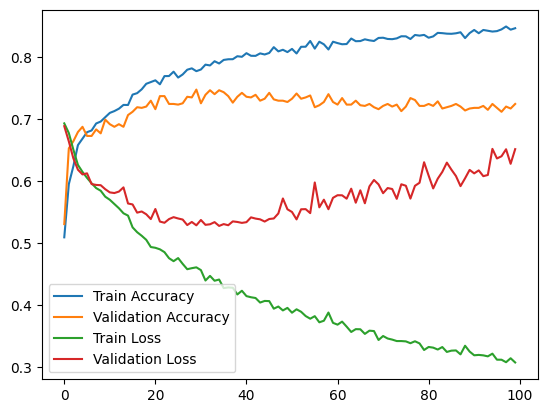

Epoch 1/100
34/34 [==============================] - 2s 40ms/step - loss: 0.6908 - accuracy: 0.5204 - val_loss: 0.6861 - val_accuracy: 0.5179
Epoch 2/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6728 - accuracy: 0.5998 - val_loss: 0.6577 - val_accuracy: 0.6253
Epoch 3/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6406 - accuracy: 0.6343 - val_loss: 0.6232 - val_accuracy: 0.6800
Epoch 4/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6151 - accuracy: 0.6656 - val_loss: 0.6080 - val_accuracy: 0.6926
Epoch 5/100
34/34 [==============================] - 1s 35ms/step - loss: 0.5987 - accuracy: 0.6845 - val_loss: 0.5966 - val_accuracy: 0.7042
Epoch 6/100
34/34 [==============================] - 1s 35ms/step - loss: 0.5830 - accuracy: 0.7008 - val_loss: 0.5836 - val_accuracy: 0.7105
Epoch 7/100
34/34 [==============================] - 1s 35ms/step - loss: 0.5598 - accuracy: 0.7196 - val_loss: 0.5691 - val_accuracy: 0.7158
Epoch 

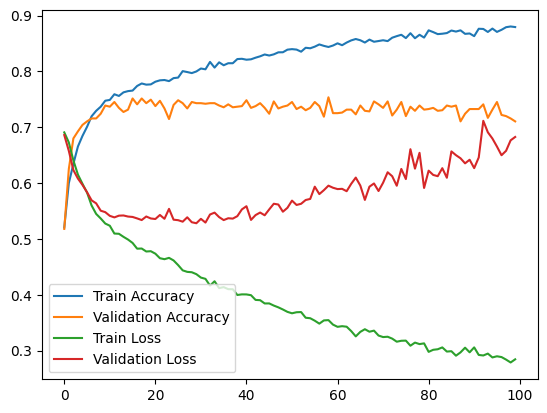

Epoch 1/100
34/34 [==============================] - 2s 40ms/step - loss: 0.6904 - accuracy: 0.5230 - val_loss: 0.6863 - val_accuracy: 0.5811
Epoch 2/100
34/34 [==============================] - 1s 36ms/step - loss: 0.6756 - accuracy: 0.5858 - val_loss: 0.6662 - val_accuracy: 0.6411
Epoch 3/100
34/34 [==============================] - 1s 36ms/step - loss: 0.6445 - accuracy: 0.6335 - val_loss: 0.6349 - val_accuracy: 0.6579
Epoch 4/100
34/34 [==============================] - 1s 36ms/step - loss: 0.6195 - accuracy: 0.6685 - val_loss: 0.6142 - val_accuracy: 0.6726
Epoch 5/100
34/34 [==============================] - 1s 35ms/step - loss: 0.5981 - accuracy: 0.6807 - val_loss: 0.6054 - val_accuracy: 0.6653
Epoch 6/100
34/34 [==============================] - 1s 35ms/step - loss: 0.5807 - accuracy: 0.6965 - val_loss: 0.5866 - val_accuracy: 0.7074
Epoch 7/100
34/34 [==============================] - 1s 36ms/step - loss: 0.5641 - accuracy: 0.7129 - val_loss: 0.5738 - val_accuracy: 0.7126
Epoch 

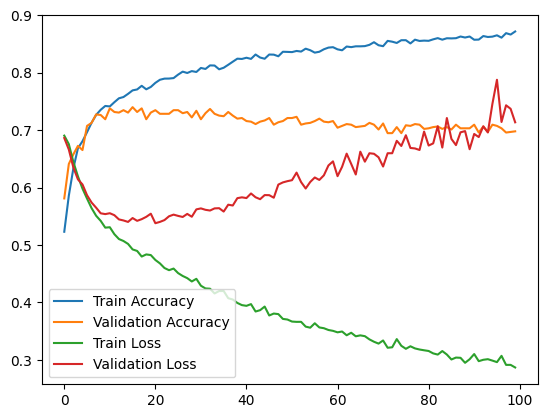

Epoch 1/100
34/34 [==============================] - 2s 39ms/step - loss: 0.6941 - accuracy: 0.5112 - val_loss: 0.6923 - val_accuracy: 0.5705
Epoch 2/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6916 - accuracy: 0.5364 - val_loss: 0.6896 - val_accuracy: 0.5874
Epoch 3/100
34/34 [==============================] - 1s 36ms/step - loss: 0.6835 - accuracy: 0.5667 - val_loss: 0.6732 - val_accuracy: 0.6347
Epoch 4/100
34/34 [==============================] - 1s 34ms/step - loss: 0.6579 - accuracy: 0.5983 - val_loss: 0.6418 - val_accuracy: 0.6379
Epoch 5/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6366 - accuracy: 0.6177 - val_loss: 0.6274 - val_accuracy: 0.6674
Epoch 6/100
34/34 [==============================] - 1s 34ms/step - loss: 0.6209 - accuracy: 0.6422 - val_loss: 0.6108 - val_accuracy: 0.6674
Epoch 7/100
34/34 [==============================] - 1s 34ms/step - loss: 0.6095 - accuracy: 0.6453 - val_loss: 0.6118 - val_accuracy: 0.6642
Epoch 

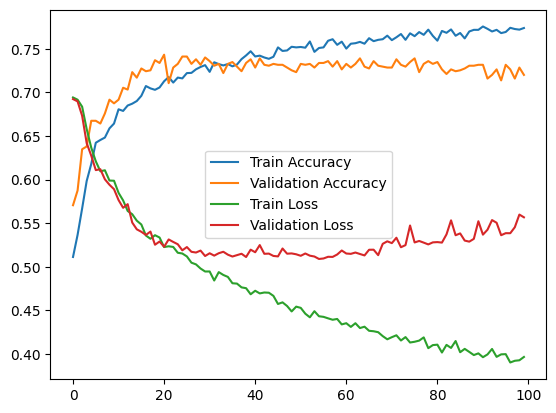

Epoch 1/100
34/34 [==============================] - 2s 39ms/step - loss: 0.6921 - accuracy: 0.5184 - val_loss: 0.6891 - val_accuracy: 0.5211
Epoch 2/100
34/34 [==============================] - 1s 34ms/step - loss: 0.6801 - accuracy: 0.5692 - val_loss: 0.6767 - val_accuracy: 0.5779
Epoch 3/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6491 - accuracy: 0.6360 - val_loss: 0.6475 - val_accuracy: 0.6232
Epoch 4/100
34/34 [==============================] - 1s 37ms/step - loss: 0.6257 - accuracy: 0.6540 - val_loss: 0.6243 - val_accuracy: 0.6653
Epoch 5/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6133 - accuracy: 0.6644 - val_loss: 0.6092 - val_accuracy: 0.6716
Epoch 6/100
34/34 [==============================] - 1s 35ms/step - loss: 0.5990 - accuracy: 0.6782 - val_loss: 0.5989 - val_accuracy: 0.6884
Epoch 7/100
34/34 [==============================] - 1s 35ms/step - loss: 0.5908 - accuracy: 0.6864 - val_loss: 0.5934 - val_accuracy: 0.7011
Epoch 

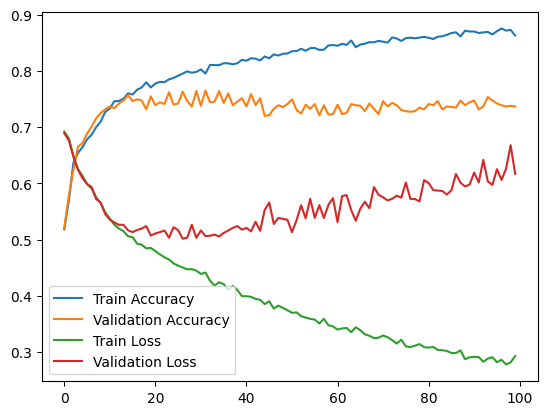

Epoch 1/100
34/34 [==============================] - 2s 41ms/step - loss: 0.6878 - accuracy: 0.5370 - val_loss: 0.6823 - val_accuracy: 0.5800
Epoch 2/100
34/34 [==============================] - 1s 36ms/step - loss: 0.6639 - accuracy: 0.6095 - val_loss: 0.6494 - val_accuracy: 0.6400
Epoch 3/100
34/34 [==============================] - 1s 36ms/step - loss: 0.6264 - accuracy: 0.6539 - val_loss: 0.6178 - val_accuracy: 0.6642
Epoch 4/100
34/34 [==============================] - 1s 35ms/step - loss: 0.6055 - accuracy: 0.6713 - val_loss: 0.6236 - val_accuracy: 0.6547
Epoch 5/100
34/34 [==============================] - 1s 37ms/step - loss: 0.5954 - accuracy: 0.6872 - val_loss: 0.6113 - val_accuracy: 0.6632
Epoch 6/100
34/34 [==============================] - 1s 36ms/step - loss: 0.5840 - accuracy: 0.6989 - val_loss: 0.5863 - val_accuracy: 0.6979
Epoch 7/100
34/34 [==============================] - 1s 36ms/step - loss: 0.5653 - accuracy: 0.7135 - val_loss: 0.5802 - val_accuracy: 0.7011
Epoch 

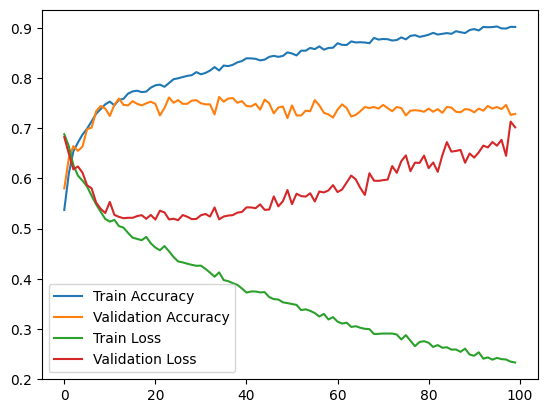

Epoch 1/100
34/34 [==============================] - 2s 43ms/step - loss: 0.6922 - accuracy: 0.5143 - val_loss: 0.6916 - val_accuracy: 0.5279
Epoch 2/100
34/34 [==============================] - 1s 38ms/step - loss: 0.6853 - accuracy: 0.5684 - val_loss: 0.6815 - val_accuracy: 0.6164
Epoch 3/100
34/34 [==============================] - 1s 39ms/step - loss: 0.6666 - accuracy: 0.5988 - val_loss: 0.6607 - val_accuracy: 0.6280
Epoch 4/100
34/34 [==============================] - 1s 39ms/step - loss: 0.6453 - accuracy: 0.6165 - val_loss: 0.6459 - val_accuracy: 0.6407
Epoch 5/100
34/34 [==============================] - 1s 37ms/step - loss: 0.6287 - accuracy: 0.6289 - val_loss: 0.6325 - val_accuracy: 0.6344
Epoch 6/100
34/34 [==============================] - 1s 38ms/step - loss: 0.6165 - accuracy: 0.6462 - val_loss: 0.6288 - val_accuracy: 0.6354
Epoch 7/100
34/34 [==============================] - 1s 40ms/step - loss: 0.6149 - accuracy: 0.6519 - val_loss: 0.6198 - val_accuracy: 0.6502
Epoch 

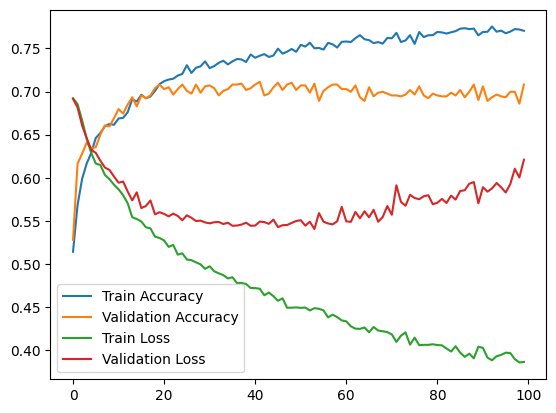

In [11]:
kfold = KFold(10, shuffle=True)

# initialize average variables
avg_acc, avg_mcc, avg_sp, avg_sn = 0, 0, 0, 0

for train, val in kfold.split(X_train_full_embedding, y_train_full):

    # Early stopping
    es = EarlyStopping(monitor='val_accuracy', patience=3, mode='auto')

    # Checkpointer
    metric = 'val_accuracy'
    checkpointer = ModelCheckpoint(filepath="../models/st_model_best.h5",
                            monitor = metric,
                            verbose=0, 
                            save_weights_only=False,
                            save_best_only=True)

    model = CNN_Embedding()
    model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

    # seperate val data
    X_train, X_val = X_train_full_embedding[train], X_train_full_embedding[val]
    y_train, y_val = y_train_full[train], y_train_full[val]

    # Training and Evaluation
    history = model.fit(X_train, y_train, batch_size=256, epochs=100, verbose=1, callbacks=[checkpointer],
                            validation_data=(X_val, y_val))


    y_pred = model.predict(X_val).reshape(y_val.shape[0],)

    y_pred = (y_pred > 0.5)
    y_pred = [int(i) for i in y_pred]
    y_val = np.array(y_val)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_val, y_pred)
    mcc = matthews_corrcoef(y_val, y_pred)
    acc = accuracy_score(y_val, y_pred)
    sn = cm[1][1]/(cm[1][1]+cm[1][0])
    sp = cm[0][0]/(cm[0][0]+cm[0][1])
    print(acc,mcc,sn,sp)
    print("CM: ", cm)
    plot(history)